In [1]:
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from matplotlib import pyplot as plt

Reading the raw dataset.

In [2]:
ds = load_dataset(
    "mlburnham/dem_rep_party_platform_topics",
    revision="08af680e8575e47c4f49e69bc458c5a423b8376b"
)
df = concatenate_datasets(ds.values()).to_pandas()
df

README.md:   0%|          | 0.00/799 [00:00<?, ?B/s]

(…)-00000-of-00001-6f3e426c1bd48c74.parquet:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

(…)-00000-of-00001-c4fd45720d03eaae.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15438 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4734 [00:00<?, ? examples/s]

,premise,target,hypothesis,entailment,validation_label,dataset,validation_source
0,Ours is the party under which this nation befo...,foreign aid,This text is about foreign aid.,0,0,Dem. Party Platforms,GPT-4-1106-preview
1,Ours is the party under whose leadership farm ...,agriculture,This text is about agriculture.,0,0,Dem. Party Platforms,GPT-4-1106-preview
2,Ours is the party which first proclaimed that ...,international affairs,This text is about international affairs.,0,0,Dem. Party Platforms,GPT-4-1106-preview
3,Before the end of the war the Democratic admin...,international affairs,This text is about international affairs.,0,0,Dem. Party Platforms,GPT-4-1106-preview
4,We pledge our best endeavors to conclude treat...,international affairs,This text is about international affairs.,0,0,Dem. Party Platforms,GPT-4-1106-preview
...,...,...,...,...,...,...,...
20167,We emphatically reject U.N. Agenda 21 as erosi...,exchange rates,This text is about exchange rates.,1,1,Rep. Party Platforms,GPT-4-1106-preview
20168,The advance of political freedom and entrepren...,tariff & imports,This text is about tariff & imports.,1,1,Rep. Party Platforms,GPT-4-1106-preview
20169,Radical Islamic terrorism poses an existential...,police,This text is about police.,1,1,Rep. Party Platforms,GPT-4-1106-preview
20170,Cybersecurity in an Insecure World. Cyber atta...,fair labor standards,This text is about fair labor standards.,1,1,Rep. Party Platforms,GPT-4-1106-preview


Dropping useless columns.

In [3]:
df = df.drop(columns=["target", "hypothesis", "entailment", "validation_label", "validation_source"])

Renaming columns.

In [4]:
df = df.rename(columns={"premise": "body", "dataset": "leaning"})

Categorizing the leaning column.

In [5]:
df["leaning"].unique()

array(['Dem. Party Platforms', 'Rep. Party Platforms'], dtype=object)

In [6]:
df["leaning"] = df["leaning"].replace({"Dem. Party Platforms": "left", "Rep. Party Platforms": "right"})
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [7]:
df = df.dropna()

Printing duplicates.

In [8]:
df[df["body"].duplicated(keep=False)]

,body,leaning
0,Ours is the party under which this nation befo...,left
2,Ours is the party which first proclaimed that ...,left
3,Before the end of the war the Democratic admin...,left
4,We pledge our best endeavors to conclude treat...,left
5,We shall strive to conclude treaties with the ...,left
...,...,...
20165,Our continued participation in the United Nati...,right
20167,We emphatically reject U.N. Agenda 21 as erosi...,right
20169,Radical Islamic terrorism poses an existential...,right
20170,Cybersecurity in an Insecure World. Cyber atta...,right


Dropping the duplicates.

In [9]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [10]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,body,leaning,body_length,body_word_count
6285,We must pay down the debt to keep interest rat...,left,53,11
15360,"For a veteran, a job is more than a source of ...",right,53,12
5486,"To an entrepreneur, it means a shot at a new b...",left,54,11
2037,We believe in equal pay for equal work and pay...,left,54,11
5306,"As we enter the 1980s, we must enact grand jur...",left,55,11


In [11]:
df["body_length"].mean()

np.float64(390.1289150372037)

The leaning distribution.

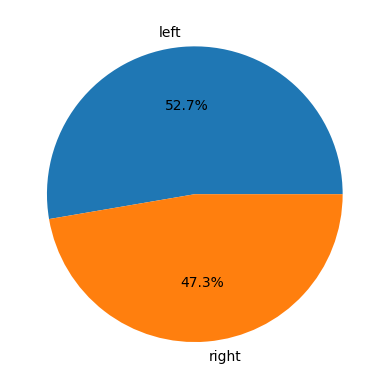

In [12]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

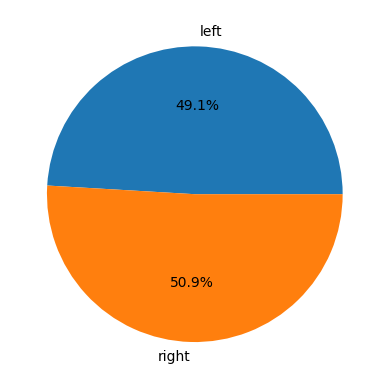

In [13]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

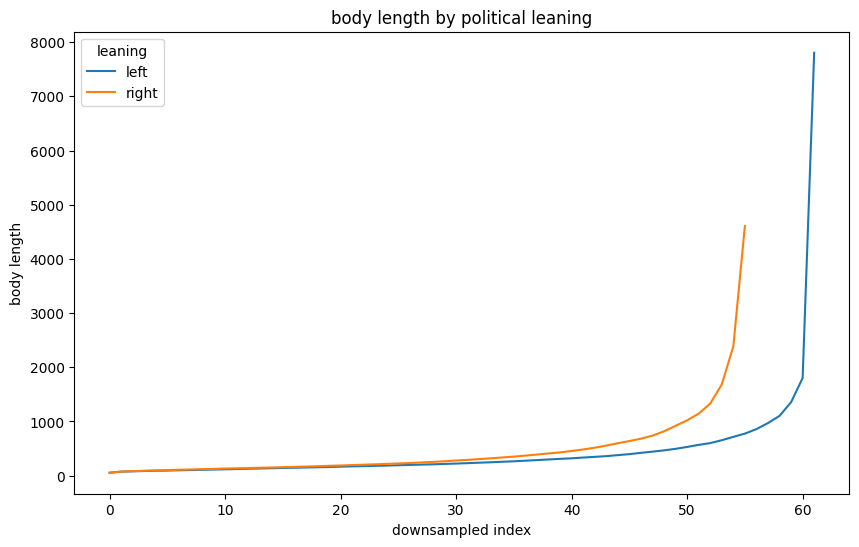

In [14]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [15]:
df.to_parquet("../preprocessed/dem_rep_party_platform_topics.parquet")

In [16]:
df

,body,leaning,body_length,body_word_count
6285,We must pay down the debt to keep interest rat...,left,53,11
15360,"For a veteran, a job is more than a source of ...",right,53,12
5486,"To an entrepreneur, it means a shot at a new b...",left,54,11
2037,We believe in equal pay for equal work and pay...,left,54,11
5306,"As we enter the 1980s, we must enact grand jur...",left,55,11
...,...,...,...,...
3137,Honoring Indigenous Tribal Nations We have a p...,left,5404,796
2679,Preventing the Spread and Use of Weapons of Ma...,left,5798,899
779,The last ten years have seen a massive shift i...,left,6058,940
3499,We also support Indian Tribal jurisdiction ov...,left,6335,904
